In [28]:
import pandas as pd                       # churn_project.py
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)

In [29]:
print("Loading dataset...")     # 1. LOAD DATA
df = pd.read_csv("churn.csv")
print("First 5 rows:")
print(df.head())
print("\nInfo:")
print(df.info())

Loading dataset...
First 5 rows:
   V1   V2   V3         V4    V5    V6  V7     V8   V9    V10  ...  V12  \
0  KS  128  415   382-4657    no   yes  25  265.1  110  45.07  ...   99   
1  OH  107  415   371-7191    no   yes  26  161.6  123  27.47  ...  103   
2  NJ  137  415   358-1921    no    no   0  243.4  114  41.38  ...  110   
3  OH   84  408   375-9999   yes    no   0  299.4   71  50.90  ...   88   
4  OK   75  415   330-6626   yes    no   0  166.7  113  28.34  ...  122   

     V13    V14  V15    V16   V17  V18   V19  V20      V21  
0  16.78  244.7   91  11.01  10.0    3  2.70    1   False.  
1  16.62  254.4  103  11.45  13.7    3  3.70    1   False.  
2  10.30  162.6  104   7.32  12.2    5  3.29    0   False.  
3   5.26  196.9   89   8.86   6.6    7  1.78    2   False.  
4  12.61  186.9  121   8.41  10.1    3  2.73    3   False.  

[5 rows x 21 columns]

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column  

In [30]:
# 2. BASIC CLEANING / ENCODING
# If customerID exists, drop it (not useful as a feature)
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

In [31]:
if df["V21"].dtype == "object":
    # The dataset uses 'False.' and 'True.' for the target variable, convert them to 0 and 1
    # Strip any whitespace before mapping to ensure exact matches
    df["V21"] = df["V21"].astype(str).str.strip().map({"False.": 0, "True.": 1})


print("\nChurn value counts (after encoding):")
print(df["V21"].value_counts())


Churn value counts (after encoding):
V21
0    4293
1     707
Name: count, dtype: int64


In [33]:
cat_cols = df.select_dtypes(include="object").columns.tolist()   # Encode categorical feature columns
print("\nCategorical columns:", cat_cols)

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print("\nData after encoding (head):")
print(df.head())


Categorical columns: ['V1', 'V4', 'V5', 'V6']

Data after encoding (head):
   V1   V2   V3    V4  V5  V6  V7     V8   V9    V10  ...  V12    V13    V14  \
0  16  128  415  2845   0   1  25  265.1  110  45.07  ...   99  16.78  244.7   
1  35  107  415  2301   0   1  26  161.6  123  27.47  ...  103  16.62  254.4   
2  31  137  415  1616   0   0   0  243.4  114  41.38  ...  110  10.30  162.6   
3  35   84  408  2510   1   0   0  299.4   71  50.90  ...   88   5.26  196.9   
4  36   75  415   155   1   0   0  166.7  113  28.34  ...  122  12.61  186.9   

   V15    V16   V17  V18   V19  V20  V21  
0   91  11.01  10.0    3  2.70    1    0  
1  103  11.45  13.7    3  3.70    1    0  
2  104   7.32  12.2    5  3.29    0    0  
3   89   8.86   6.6    7  1.78    2    0  
4  121   8.41  10.1    3  2.73    3    0  

[5 rows x 21 columns]


In [34]:
sns.set_style("whitegrid")  # 3. EXPLORATORY DATA ANALYSIS (GRAPHS)

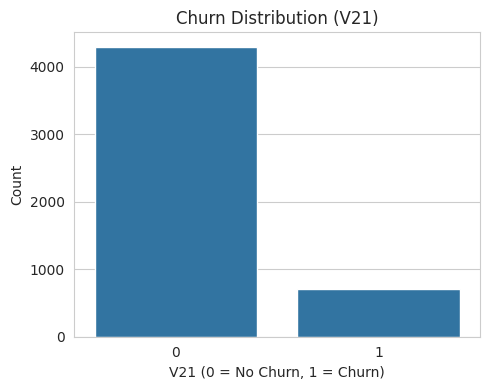

In [36]:
plt.figure(figsize=(5, 4))               # 3.1 Churn Distribution
sns.countplot(x="V21", data=df)
plt.title("Churn Distribution (V21)")
plt.xlabel("V21 (0 = No Churn, 1 = Churn)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

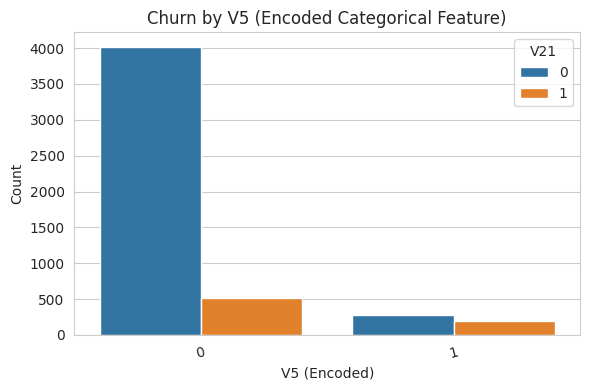

In [41]:
if "V5" in df.columns:                        # 3.2 Churn by a categorical feature (using V5)
    plt.figure(figsize=(6, 4))
    sns.countplot(x="V5", hue="V21", data=df)
    plt.title("Churn by V5 (Encoded Categorical Feature)")
    plt.xlabel("V5 (Encoded)")
    plt.ylabel("Count")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
else:
    print("\n[Info] Column 'V5' not found, skipping churn-by-V5 plot.")

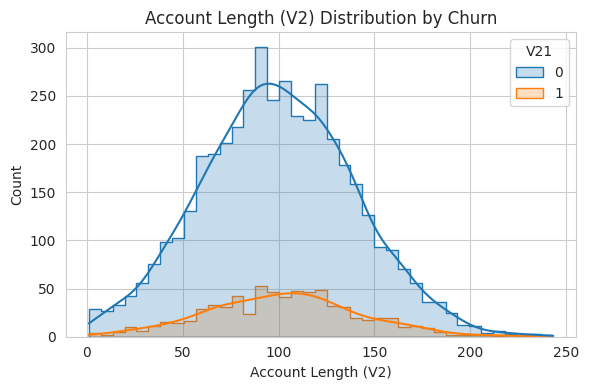

In [40]:
# 3.3 Distribution of a numerical feature by churn (using V2 as a proxy for Tenure)
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x="V2", hue="V21", kde=True, element="step")
plt.title("Account Length (V2) Distribution by Churn")
plt.xlabel("Account Length (V2)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

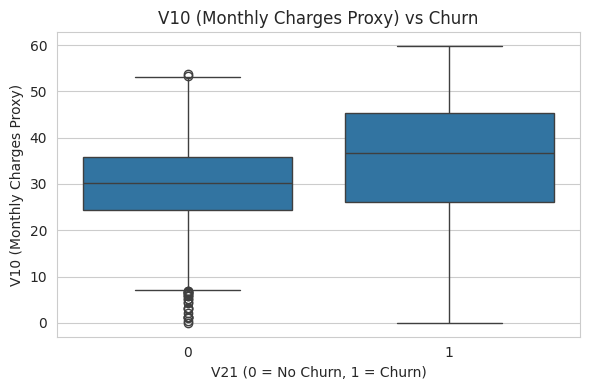

In [42]:
# 3.4 Boxplot for a numerical feature (using V10 as a proxy for Monthly Charges) by Churn
plt.figure(figsize=(6, 4))
sns.boxplot(x="V21", y="V10", data=df)
plt.title("V10 (Monthly Charges Proxy) vs Churn")
plt.xlabel("V21 (0 = No Churn, 1 = Churn)")
plt.ylabel("V10 (Monthly Charges Proxy)")
plt.tight_layout()
plt.show()

In [43]:
num_cols = [c for c in df.columns if df[c].dtype != "object" and c != "V21"]
if num_cols:
    print("\nNumeric columns:", num_cols)
    summary = df.groupby("V21")[num_cols].mean()
    print("\nAverage numeric values by churn status:")
    print(summary)
else:
    print("\n[Info] No numeric columns for summary besides V21.")


Numeric columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']

Average numeric values by churn status:
            V1          V2          V3           V4        V5        V6  \
V21                                                                       
0    25.956674   99.917074  436.736781  2492.253902  0.063825  0.284416   
1    26.251768  102.332390  437.971711  2543.499293  0.281471  0.144272   

           V7          V8          V9        V10         V11         V12  \
V21                                                                        
0    8.291870  175.746564   99.899604  29.877494  198.805031  100.241556   
1    4.496464  207.870580  100.817539  35.338416  211.757850   99.884017   

           V13         V14        V15       V16        V17       V18  \
V21                                                                    
0    16.898654  199.455113  99.975775  8.975593  10.190869 

In [44]:
X = df.drop("V21", axis=1)
y = df["V21"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (4000, 20) Test shape: (1000, 20)


Model training complete.

Accuracy: 0.87

Confusion Matrix:
 [[842  17]
 [113  28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       859
           1       0.62      0.20      0.30       141

    accuracy                           0.87      1000
   macro avg       0.75      0.59      0.61      1000
weighted avg       0.85      0.87      0.84      1000



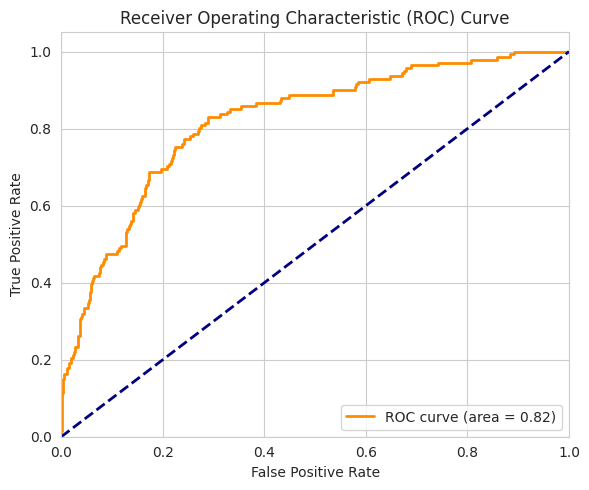

In [45]:
# 5. MODEL TRAINING
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# 6. MODEL EVALUATION
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()